# Think Aloud fMRI analysis

In [4]:
import os
import math
import copy
import shutil
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import scipy.io
import nibabel as nb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# load subject info
sdf = pd.read_excel('participant_info.xlsx')

# drop subjects
sdf = sdf[sdf['drop_fmri_bin'] != 1].reset_index(drop=True)
subjects = sdf['BIDS_ID']

In [6]:
# load behavioral data
sentencedata = list()
for i in range(len(subjects)):    
    sentencedata.append(pd.read_excel(os.path.join('behav_data', subjects[i] + '_transcripts.xlsx'),index_col=0))
    
# boundary agreement (probabilty) for all thoughts
with open(os.path.join('boundary_agreement.pickcle'), 'rb') as file:
    allsubj_boundary_data = pickle.load(file)

In [8]:
# new dataframe with each row = thought
TR = 1.5
scandur = 400 # total TRs in a scan
hrfshift = 3 # shift timestamps 3 TRs forward to account for hrf delay
durthr = 10 # select thoughts > 10 TRs to generate non-boundary templates

thoughtdata = list()
for i in range(len(sentencedata)):
    thoughtdata.append(sentencedata[i][['category','thoughtID']].groupby(['thoughtID']).mean().reset_index())
    df = sentencedata[i].groupby(['thoughtID'])['Transcribed Sentence'].apply(' '.join).reset_index()
    thoughtdata[i]['Transcribed Sentence'] = df['Transcribed Sentence']
    
    # add topic column
    df = sentencedata[i].groupby(['thoughtID'])['topic'].unique().apply(lambda x: x[0]).reset_index()
    thoughtdata[i]['topic'] = df['topic']
    
    # add start/end times of each thought
    starts = list()
    ends = list()
    starts_TR = list()
    ends_TR = list()
    for t in range(len(thoughtdata[i])):
        thisstart = sentencedata[i][sentencedata[i]['thoughtID']==t+1]['Start Time'].reset_index()
        thisend = sentencedata[i][sentencedata[i]['thoughtID']==t+1]['End Time'].reset_index()
        starts.append(thisstart['Start Time'][0])
        ends.append(thisend['End Time'][len(thisend)-1])
        starts_TR.append(round((thisstart['Start Time'][0])/TR))
        ends_TR.append(round((thisend['End Time'][len(thisend)-1])/TR))

    thoughtdata[i]['start_sec'] = starts
    thoughtdata[i]['end_sec'] = ends
    thoughtdata[i]['start_TR'] = starts_TR
    thoughtdata[i]['end_TR'] = ends_TR
    
    # add category/topic change columns
    thoughtdata[i]['category_change'] = np.empty((len(thoughtdata[i])))+np.nan
    thoughtdata[i]['category_change'][:-1] = thoughtdata[i]['category'][:-1].values != thoughtdata[i]['category'][1:].values
    thoughtdata[i]['topic_change'] = np.empty((len(thoughtdata[i])))+np.nan
    thoughtdata[i]['topic_change'][:-1] = thoughtdata[i]['topic'][:-1].values != thoughtdata[i]['topic'][1:].values
    thoughtdata[i]['category_change_only'] = (thoughtdata[i]['category_change'] == True) & (thoughtdata[i]['topic_change'] == False)
    thoughtdata[i]['topic_change_only'] = (thoughtdata[i]['category_change'] == False) & (thoughtdata[i]['topic_change'] == True)
    thoughtdata[i]['both_change'] = (thoughtdata[i]['category_change'] == True) & (thoughtdata[i]['topic_change'] == True)
    
    # trim thoughts lasted longer than the scan
    if thoughtdata[i]['end_TR'].iloc[-1] > scandur:
        thoughtdata[i]['end_TR'].iloc[-1] = scandur
    
    # add the shifted time column
    thoughtdata[i]['start_TR_shifted'] = thoughtdata[i]['start_TR'] + hrfshift
    thoughtdata[i]['end_TR_shifted'] = thoughtdata[i]['end_TR'] + hrfshift
   
    # identify thoughts longer than the threshold
    thoughtdata[i]['long'] = (thoughtdata[i]['end_TR_shifted'] - thoughtdata[i]['start_TR_shifted']) > durthr
    
    # boundary agreement scores & strong boundaries
    idx = np.where(np.isin( round(allsubj_boundary_data[sdf['subjID'][i]]['sec_adj'],2),round(thoughtdata[i]['end_sec'],2)))[0]
    thoughtdata[i]['boundary_agreement'] = allsubj_boundary_data[sdf['subjID'][i]]['prob'][idx]
    thoughtdata[i]['strong_boundary'] = thoughtdata[i]['boundary_agreement']==1
    thoughtdata[i]['strong_boundary'][len(thoughtdata[i])-1] = False

## Similarity to the FilmFest pattern

In [53]:
def drop_TRs(image, fd, fddrop, startdrop):
  
    if fddrop != 0:
        threshold = 1 # fd outlier threshold (1mm)
        indices = np.where(fd >= threshold)[0]

        combined_indices = np.array([],dtype=int)
        for i in indices:
            for j in range(1, fddrop+1):
                if i - j >= 0:
                    combined_indices = np.append(combined_indices, i - j)
            combined_indices = np.append(combined_indices, i)
            for j in range(1, fddrop+1):
                if i + j < fd.shape[0]:
                    combined_indices = np.append(combined_indices, i + j)
        combined_indices = np.unique(combined_indices)

        image[:, combined_indices] = np.nan
        
    image[:, :startdrop] = np.nan

    return image

# load and combine roi time courses from the two hemispheres for all subjs
def load_roi_tcs(subjects, roiname, space, drop):

    roitc = list()
    for ss in range(len(subjects)):

        # load roitc (vertex X TR)
        roitc_L = np.load(os.path.join('roitc',subjects[ss],subjects[ss] + '_task-thinkaloud_hemi-L_space-' + space + '_desc-sm4zscored_bold_' + roiname + '.npy'))
        roitc_R = np.load(os.path.join('roitc',subjects[ss],subjects[ss] + '_task-thinkaloud_hemi-R_space-' + space + '_desc-sm4zscored_bold_' + roiname + '.npy'))

        # drop the beginning & motion outlier TRs
        if drop == 1:
            confdf = pd.read_csv(os.path.join('confounds',subjects[ss] + '_framewise_displacement.csv'))
            roitc_L = drop_TRs(roitc_L, np.array(confdf['framewise_displacement']), 2, 10)
            roitc_R = drop_TRs(roitc_R, np.array(confdf['framewise_displacement']), 2, 10)
            
        # combine across hemispheres
        roitc.append(np.concatenate((roitc_L, roitc_R),axis=0))
        
    return roitc

# load filmfest template files (10 TRs from the offset -- exactly the same templates used in the elife paper)
def load_templates(roiname):
    movofftemplate = scipy.io.loadmat(os.path.join('filmfest_templates',roiname + '_bilateral_movoffset.mat'))
    movofftemplate = np.squeeze(movofftemplate['template'])

    silencetemplate = scipy.io.loadmat(os.path.join('filmfest_templates',roiname + '_bilateral_silence.mat'))
    silencetemplate = np.squeeze(silencetemplate['template'])
    
    return movofftemplate, silencetemplate

# create middle & strong boundary patterns for a single subj, exclude overlapping TRs
def make_templates_new(roitc, behavdata, timevar, windowsize, scandur, shift):
    
    middletimes = round((behavdata['start_TR_shifted'] + behavdata['end_TR_shifted'])/2)
    middletimes = middletimes[behavdata['long']==True].apply(lambda x: int(x)).values
    middle_TRs = list()
    for t in range(windowsize):
        middle_TRs.append(middletimes - math.floor(windowsize/2) + t)
    middle_TRs = np.reshape(np.unique(np.array(middle_TRs)),-1)
    middle_TRs = np.delete(middle_TRs, middle_TRs > scandur)
    middle_TRs = np.delete(middle_TRs, middle_TRs <= 0)

    if timevar=='end_TR_shifted':
        boundarytimes = behavdata[timevar][behavdata['strong_boundary']==True].values
    elif timevar=='start_TR_shifted':
        thisidx = (behavdata[behavdata['strong_boundary']==True].index)+1
        thisidx = np.delete(thisidx, thisidx>=len(behavdata))
        boundarytimes = behavdata[timevar][thisidx].values
    boundaryTRs = [boundarytimes + t for t in range(windowsize)]
    boundaryTRs = np.reshape(np.unique(np.array(boundaryTRs)),-1)+shift
    boundaryTRs = np.delete(boundaryTRs, boundaryTRs > scandur)
    boundaryTRs = np.delete(boundaryTRs, boundaryTRs <= 0)
    
    # exclude overlapping TRs
    overlapping_TR = np.intersect1d(middle_TRs, boundaryTRs)
    indices_middle = np.where(np.isin(middle_TRs, overlapping_TR))[0]
    indices_strong = np.where(np.isin(boundaryTRs, overlapping_TR))[0]    
    middle_TRs = np.delete(middle_TRs, indices_middle) 
    boundaryTRs = np.delete(boundaryTRs, indices_strong) 
    
    middle_template = np.nanmean(roitc[:,middle_TRs-1], axis=1)   
    strong_template = np.nanmean(roitc[:, boundaryTRs-1], axis=1)
    
    return middle_template, strong_template  

# similariy with filmfest template patterns for all subjs
def filmfest_template_analysis(subjects, roiname, behavdata, windowsize, timevar, shift):
   
    # load Filmfest template patterns (window=10TR)
    filmfest_template = load_templates(roiname)

    # load roi time courses for all subjs
    roitc = load_roi_tcs(subjects, roiname, 'fsaverage6', 1)

    # create thinkaloud templates
    middle_template = list()
    strong_template = list()
    for i in range(len(subjects)):
        middle, strong = make_templates_new(roitc[i], thoughtdata[i], timevar, wsize, 400, shift)
        middle_template.append(middle)
        strong_template.append(strong)
    
    templates = [middle_template, strong_template]
    
    # correlate thinkaloud and FilmFest templates
    result = list()
    varnames = ['middle','strong']
    for cond in range(len(filmfest_template)):

        result.append(pd.DataFrame({'subjects':subjects,
                                    'r_middle':np.zeros(len(subjects)),'p_middle':np.zeros(len(subjects)),
                                    'r_strong':np.zeros(len(subjects)),'p_strong':np.zeros(len(subjects))}))

        for i in range(len(subjects)):
            for j in range(len(templates)):
                if np.any(np.isnan(templates[j][i])):
                    result[cond]['r_' + varnames[j]][i] = np.nan
                    result[cond]['p_' + varnames[j]][i] = np.nan
                else:
                    result[cond]['r_' + varnames[j]][i], result[cond]['p_' + varnames[j]][i] = sp.stats.pearsonr(templates[j][i], filmfest_template[cond])
    
    return templates, result

### PMC

In [55]:
wsize = 4 # time window for averaging across TRs 

roiname = 'PMC'
templates, result = filmfest_template_analysis(subjects, roiname, thoughtdata, wsize, 'end_TR_shifted',0)

#### Movie offset 

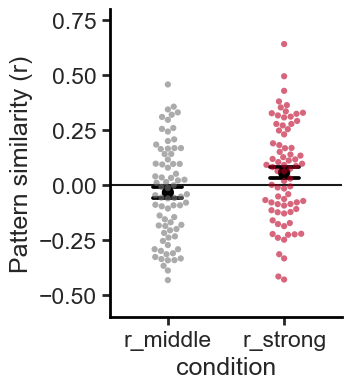

In [57]:
condidx = 0
thisvars = ['r_middle','r_strong']

# long format for group level result
longdf = pd.melt(result[condidx][['subjects','r_middle','r_strong']], 
                 id_vars='subjects', value_vars=['r_middle','r_strong'])
longdf.columns = ['subjects','condition','similarity']

sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})
transcolors = ["#737373", "#bd0026"]
f, ax = plt.subplots(figsize=(3, 4))
sns.pointplot(x='condition', y='similarity', data=longdf[(longdf['condition']=='r_middle')|(longdf['condition']=='r_strong')], 
              errorbar="se", capsize=.25, color="0", linestyles='', markers='o')
g = sns.swarmplot(x='condition', y='similarity', hue='condition', data=longdf[(longdf['condition']=='r_middle')|(longdf['condition']=='r_strong')], 
                  size=4.5, legend=False, palette=transcolors, edgecolor='none', alpha=0.6)
g.axhline(0, color='k', linewidth=1.5)
plt.ylim(-0.6,0.8)
plt.ylabel('Pattern similarity (r)');
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

#### Silence

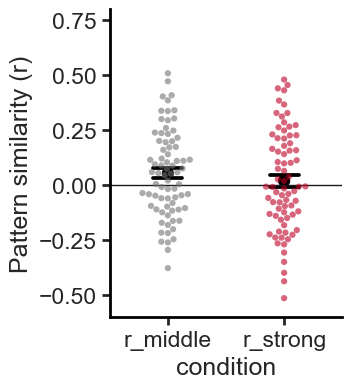

In [59]:
condidx = 1

# long format for group level result
longdf = pd.melt(result[condidx][['subjects','r_middle','r_strong']], 
                 id_vars='subjects', value_vars=['r_middle','r_strong'])
longdf.columns = ['subjects','condition','similarity']

f, ax = plt.subplots(figsize=(3, 4))
sns.pointplot(x='condition', y='similarity', data=longdf[(longdf['condition']=='r_middle')|(longdf['condition']=='r_strong')], 
              errorbar="se", capsize=.25, color="0", linestyles='', markers='o')
g = sns.swarmplot(x='condition', y='similarity', hue='condition', data=longdf[(longdf['condition']=='r_middle')|(longdf['condition']=='r_strong')], 
                  size=4.5, legend=False, palette=transcolors, edgecolor='none', alpha=0.6)
g.axhline(0, color='k', linewidth=1)
plt.ylabel('Pattern similarity (r)');
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

### Auditory

In [61]:
roiname = 'aud'
templates, result = filmfest_template_analysis(subjects, roiname, thoughtdata, wsize, 'end_TR_shifted',0)

#### Movie offset 

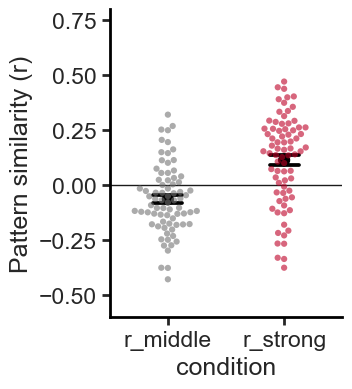

In [63]:
condidx = 0

# long format for group level result
longdf = pd.melt(result[condidx][['subjects','r_middle','r_strong']], 
                 id_vars='subjects', value_vars=['r_middle','r_strong'])
longdf.columns = ['subjects','condition','similarity']

f, ax = plt.subplots(figsize=(3, 4))
sns.pointplot(x='condition', y='similarity', data=longdf[(longdf['condition']=='r_middle')|(longdf['condition']=='r_strong')], 
              errorbar="se", capsize=.25, color="0", linestyles='', markers='o')
g = sns.swarmplot(x='condition', y='similarity', hue='condition', data=longdf[(longdf['condition']=='r_middle')|(longdf['condition']=='r_strong')], 
                  size=4.5, legend=False, palette=transcolors, edgecolor='none', alpha=0.6)
g.axhline(0, color='k', linewidth=1)
plt.ylabel('Pattern similarity (r)');
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

#### Silence

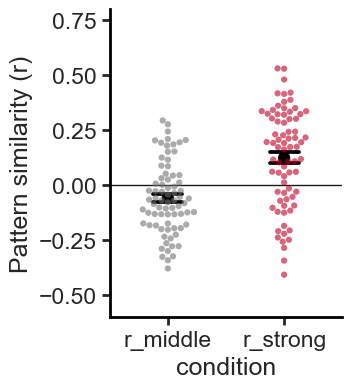

In [65]:
condidx = 1

# long format for group level result
longdf = pd.melt(result[condidx][['subjects','r_middle','r_strong']], 
                 id_vars='subjects', value_vars=['r_middle','r_strong'])
longdf.columns = ['subjects','condition','similarity']

f, ax = plt.subplots(figsize=(3, 4))
sns.pointplot(x='condition', y='similarity', data=longdf[(longdf['condition']=='r_middle')|(longdf['condition']=='r_strong')], 
              errorbar="se", capsize=.25, color="0", linestyles='', markers='o')
g = sns.swarmplot(x='condition', y='similarity', hue='condition', data=longdf[(longdf['condition']=='r_middle')|(longdf['condition']=='r_strong')], 
                  size=4.5, legend=False, palette=transcolors, edgecolor='none', alpha=0.6)
g.axhline(0, color='k', linewidth=1)
plt.ylabel('Pattern similarity (r)');
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

## PMC HMM-derived boundary 

In [79]:
from brainiak.eventseg.event import EventSegment

def HMM_percent_overlap(behavdata, nan_indices, HMM_bounds_realTRs, boundarytype):
    # boundary periods (+-1 TR from the offset shfted by 3TRs) not overlapping with dropped TRs
    boundarytimes = behavdata['end_TR_shifted'][behavdata[boundarytype]==True].values - 1 # indices starting from 0
    boundarywindows = list()
    
    for t in range(len(boundarytimes)):
        thiswindow = np.array([boundarytimes[t]-1, boundarytimes[t], boundarytimes[t]+1])
        
        if ~np.any(thiswindow >= 400):
            if np.all(~np.isin(thiswindow, nan_indices)):
                boundarywindows.append(thiswindow)
    
    # strong boundary periods overlapping with HMM boundaries
    if len(boundarywindows) > 0:
        numoverlap = 0
        for thiswindow in boundarywindows:
            if np.any(np.isin(thiswindow, HMM_bounds_realTRs))==True:
                numoverlap = numoverlap+1
        percent = 100*numoverlap/len(boundarywindows)
    else:
        percent = np.nan
        
    return percent, boundarywindows

In [81]:
roitc = load_roi_tcs(subjects, 'PMC', 'fsaverage6', 1)

strong_percent = list()
strong_HMM_bounds_all = list()
boundarywindows_all = list()

for s in range(len(thoughtdata)):    
    
    # TR-by-vertex
    thistc = np.transpose(roitc[s])

    # identify excluded TRs with NaNs
    non_nan_indices = np.where(~np.isnan(np.nanmean(thistc, axis=1)))[0]
    nan_indices = np.where(np.isnan(np.nanmean(thistc, axis=1)))[0]
    nan_indices_extended = np.unique([nan_indices,nan_indices+1,nan_indices-1])
    
    # HMM with number of states = number of strong boundaries + 1
    thought_HMM = EventSegment(n_events = sum(thoughtdata[s]['strong_boundary'])+1)
    thought_HMM.fit(thistc[non_nan_indices,:]);
    
    # event boundary indices
    HMM_bounds = np.where(np.diff(np.argmax(thought_HMM.segments_[0], axis = 1)))[0]
    HMM_bounds_realTRs = non_nan_indices[HMM_bounds]
    
    strong_HMM_bounds_all.append(HMM_bounds_realTRs)
    
    # overlap with human-labeled boundaries
    percent, boundarywindows = HMM_percent_overlap(thoughtdata[s], nan_indices_extended, HMM_bounds_realTRs, 'strong_boundary')
    strong_percent.append(percent)
    boundarywindows_all.append(boundarywindows)

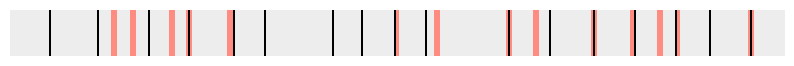

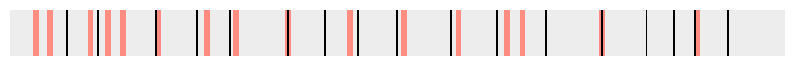

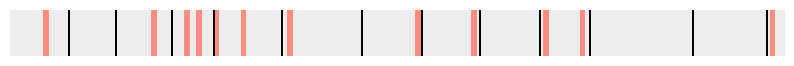

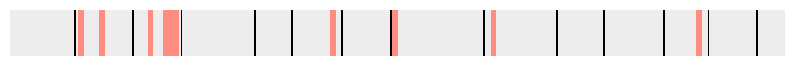

In [84]:
for i in [35,61,60,24]:
    
    tc = np.zeros(scandur)
    tc[np.unique(boundarywindows_all[i])] = 1 # human labeled
    tc[strong_HMM_bounds_all[i]] = 2 # HMM
    
    f, ax = plt.subplots(figsize=(10, 0.6));
    sns.heatmap([tc], vmin=0, vmax=2, xticklabels=False, yticklabels=False, cbar=False, cmap=[[0.93,0.93,0.93],[1,0.55,0.5],[0,0,0]])

In [ ]:
# # randomization test
# niter = 1000
# strong_percent_rand = list()

# for s in range(len(thoughtdata)):    
    
#     # TR-by-vertex
#     thistc = np.transpose(roitc[s])

#     # identify excluded TRs with NaNs
#     non_nan_indices = np.where(~np.isnan(np.mean(thistc, axis=1)))[0]
#     nan_indices = np.where(np.isnan(np.mean(thistc, axis=1)))[0]
#     nan_indices_extended = np.unique([nan_indices,nan_indices+1,nan_indices-1])

#     # boundary periods (+-1 TR from the offset shfted by 3TRs) not overlapping with dropped TRs
#     boundarytimes = thoughtdata[s]['end_TR_shifted'][thoughtdata[s]['strong_boundary']==True].values - 1 # indices starting from 0
#     boundarywindows = list()
#     for t in range(len(boundarytimes)):
#         thiswindow = np.array([boundarytimes[t]-1, boundarytimes[t], boundarytimes[t]+1])
#         if ~np.any(thiswindow >= 400):
#             if np.all(~np.isin(thiswindow, nan_indices_extended)):
#                 boundarywindows.append(thiswindow)
    
#     percent_subj = list()
#     if len(boundarywindows) > 0:
        
#         # HMM with number of states = number of strong boundaries + 1
#         thought_HMM = EventSegment(n_events = sum(thoughtdata[s]['strong_boundary'])+1)
#         thought_HMM.fit(thistc[non_nan_indices,:]);

#         # event boundary indices
#         HMM_bounds = np.where(np.diff(np.argmax(thought_HMM.segments_[0], axis = 1)))[0]
#         HMM_bounds_realTRs = non_nan_indices[HMM_bounds]

#         # random selection of boundary periods
#         nan_indices_extended = np.unique([nan_indices-2, nan_indices-1, nan_indices, nan_indices+1, nan_indices+2])
#         nan_indices_extended = np.delete(nan_indices_extended, (nan_indices_extended < 0)|(nan_indices_extended > 398))
#         for i in range(niter):

#             # random 3-TR periods not overlapping with dropped TRs & not overlapping with each other
#             indices = np.delete(np.arange(399), nan_indices_extended)  
#             randwindows = list()
#             for t in range(len(boundarywindows)):
#                 thisidx = np.random.choice(indices)
#                 randwindows.append(np.array([thisidx-1, thisidx, thisidx+1]))
#                 indices = np.delete(indices, np.where(np.isin(indices,[thisidx-2, thisidx-1, thisidx, thisidx+1, thisidx+2]))[0]) 

#             # random boundary periods overlapping with HMM boundaries
#             numoverlap = 0
#             for thiswindow in randwindows:
#                 if np.any(np.isin(thiswindow, HMM_bounds_realTRs))==True:
#                     numoverlap = numoverlap+1
#             percent_subj.append(100*numoverlap/len(randwindows))

#     else:
#         percent_subj.append(list(np.full(niter, np.nan)))
        
#     strong_percent_rand.append(percent_subj)  

0.000999000999000999


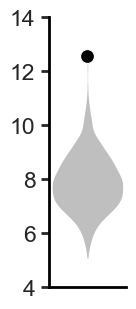

In [86]:
niter = 1000
strong_percent_rand = np.load('PMC_HMM_rand.npy')
nulldistribution = np.mean(strong_percent_rand, axis=0)

realmean = np.mean(strong_percent)
pval = (sum(nulldistribution >= realmean)+1)/(niter+1)
print(pval)

f, ax = plt.subplots(figsize=(1, 3.5))
sns.violinplot(nulldistribution, color=[0.75,0.75,0.75], inner=None, linewidth=0, cut=0)
sns.scatterplot(x=[0], y=[realmean], color="black", s=100)
plt.gca().xaxis.set_visible(False)
ax.set(ylim=[4,14]);
ax.tick_params(axis='y', width=2)

## Univariate activation

### ROI activation for different thought types

In [88]:
rois = ['PMC','hipp']
spaces = ['fsaverage6', 'MNI152NLin2009cAsym']
category_labels = ['current','episodic','semantic-self','semantic-world','future']         
numrows = len(rois)*len(subjects)*5
mean_univ = pd.DataFrame({'roi': np.ones(numrows)*np.nan, 'subject': np.ones(numrows)*np.nan, 
                          'category': np.ones(numrows)*np.nan,'activation': np.ones(numrows)*np.nan})   

idx = 0
for r in range(len(rois)):
    roitc = load_roi_tcs(subjects, rois[r], spaces[r], 1)
    
    for s in range(len(subjects)):
        
        for c in np.arange(5)+1: 
            
            mean_univ['roi'][idx] = rois[r]
            mean_univ['subject'][idx] = subjects[s]
            mean_univ['category'][idx] = category_labels[c-1]
            
            starttimes = thoughtdata[s]['start_TR_shifted'][thoughtdata[s]['category'] == c].values
            endtimes = thoughtdata[s]['end_TR_shifted'][thoughtdata[s]['category'] == c].values
            
            if len(starttimes) != 0:
                thought_univ = [np.nanmean(np.nanmean(roitc[s][:,(starttimes[t]-1):endtimes[t]],axis=0)) for t in range(len(starttimes))]
                mean_univ['activation'][idx] = np.nanmean(thought_univ)
                
            idx = idx+1

#### PMC

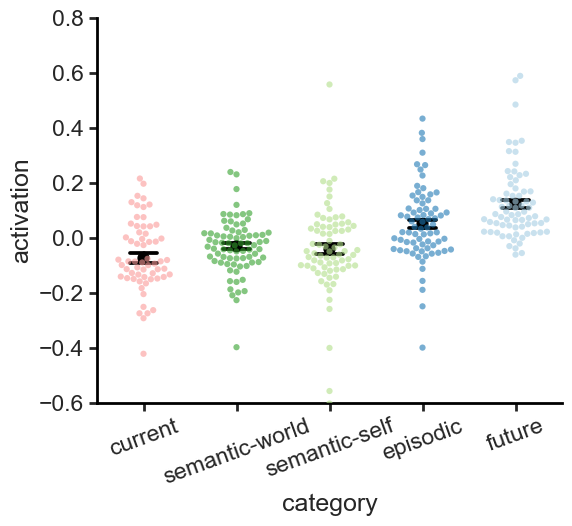

In [90]:
thisdata = mean_univ[mean_univ['roi']=='PMC']

catcolors = ["#fb9a99", "#1f78b4", "#b2df8a", "#33a02c", "#a6cee3", "#808080"]
category_order = ['current','semantic-world','semantic-self','episodic','future']         

sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})

f, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(x='category', y='activation', data=thisdata, errorbar="se", capsize=.3, color="0", linestyles='', markers='o',order=category_order)
sns.swarmplot(x='category', y='activation', hue='category', data=thisdata, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6,order=category_order)
plt.xticks([0,1,2,3,4],category_order);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

#### Hipp

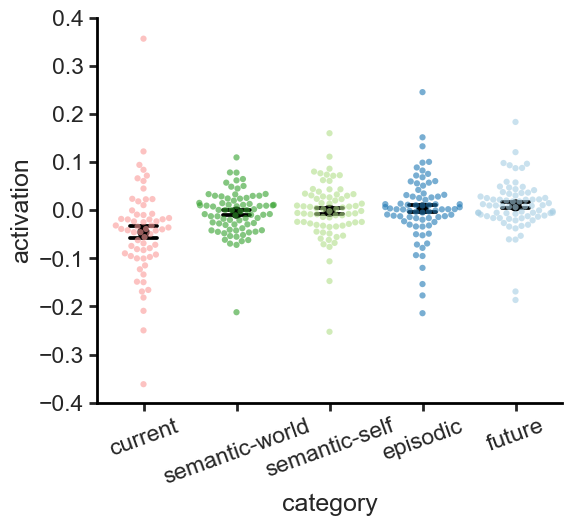

In [92]:
thisdata = mean_univ[mean_univ['roi']=='hipp']

sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})

f, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(x='category', y='activation', data=thisdata, errorbar="se", capsize=.3, color="0", linestyles='', markers='o',order=category_order)
sns.swarmplot(x='category', y='activation', hue='category', data=thisdata, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6,order=category_order)
plt.xticks([0,1,2,3,4],category_order);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);
plt.ylim(-0.4,0.4)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

### Controlling behavioral features

In [94]:
# add behavioral variables
for i in range(len(thoughtdata)):
    
    numwords = list()
    duration = list()
    density = list()
    for l in range(len(thoughtdata[i])):
        numwords.append(len(thoughtdata[i]['Transcribed Sentence'][l].split()))
        duration.append(thoughtdata[i]['end_sec'][l]-thoughtdata[i]['start_sec'][l])
        density.append(numwords[l]/duration[l])
    
    thoughtdata[i]['numwords'] = numwords
    thoughtdata[i]['duration'] = duration
    thoughtdata[i]['density'] = density

In [96]:
# event-by-event activation 
rois = ['PMC','hipp']
spaces = ['fsaverage6', 'MNI152NLin2009cAsym']

for r in range(len(rois)):
    roitc = load_roi_tcs(subjects, rois[r], spaces[r], 1)
    
    for s in range(len(subjects)):
        
        starttimes = thoughtdata[s]['start_TR_shifted'].values
        endtimes = thoughtdata[s]['end_TR_shifted'].values
        
        thoughtmean = list()
        for t in range(len(starttimes)):
            thismean = np.nanmean(np.nanmean(roitc[s][:,(starttimes[t]-1):endtimes[t]],axis=0)) 
            thoughtmean.append(thismean)
        
        thoughtdata[s]['meanactivation_' + rois[r]] = thoughtmean

In [98]:
# regressing out variables
variables = ['numwords','duration','density']
category_labels = ['current','episodic','semantic-self','semantic-world','future']         
numrows = len(rois)*len(subjects)*len(category_labels)*len(variables)
mean_regout_univ = pd.DataFrame({'roi': np.ones(numrows)*np.nan, 'controlledvariable': np.ones(numrows)*np.nan, 
                                 'subject': np.ones(numrows)*np.nan, 'category': np.ones(numrows)*np.nan,'activation': np.ones(numrows)*np.nan}) 

idx = 0
for i in range(len(thoughtdata)):
    
    # exclude rows with NaNs in activation
    selectedrows = thoughtdata[i].dropna(subset=['meanactivation_PMC'])
    
    for v in variables:
        for r in rois:
            reg = LinearRegression().fit(selectedrows[[v]], selectedrows['meanactivation_' + r])
            selectedrows['meanactivation_' + v + '_controlled_' + r] = selectedrows['meanactivation_' + r] - reg.predict(selectedrows[[v]])
            
            for c in np.arange(len(category_labels))+1: 
                
                mean_regout_univ['roi'][idx] = r
                mean_regout_univ['controlledvariable'][idx] = v
                mean_regout_univ['subject'][idx] = subjects[i]
                mean_regout_univ['category'][idx] = category_labels[c-1]
                mean_regout_univ['activation'][idx] = selectedrows[selectedrows['category'] == c]['meanactivation_' + v + '_controlled_' + r].mean() 
                
                idx = idx+1

#### PMC speech rate controlled

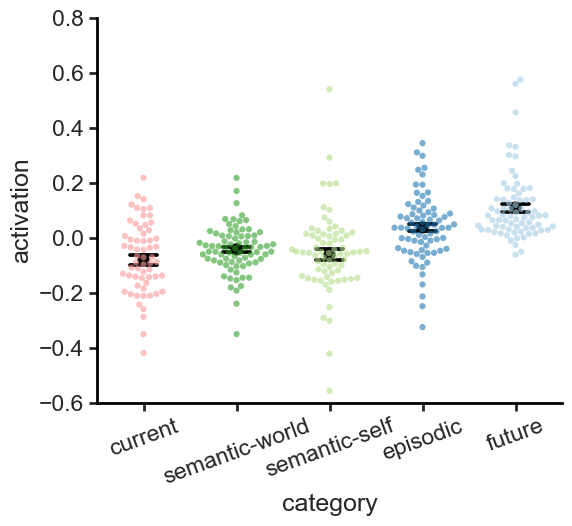

In [101]:
thisdata = mean_regout_univ[(mean_regout_univ['roi']=='PMC') & (mean_regout_univ['controlledvariable']=='density')]

catcolors = ["#fb9a99", "#1f78b4", "#b2df8a", "#33a02c", "#a6cee3", "#808080"]
category_order = ['current','semantic-world','semantic-self','episodic','future']         

sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})

f, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(x='category', y='activation', data=thisdata, errorbar="se", capsize=.3, color="0", linestyles='', markers='o',order=category_order)
sns.swarmplot(x='category', y='activation', hue='category', data=thisdata, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6,order=category_order)
plt.xticks([0,1,2,3,4],category_order);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

#### PMC duration controlled

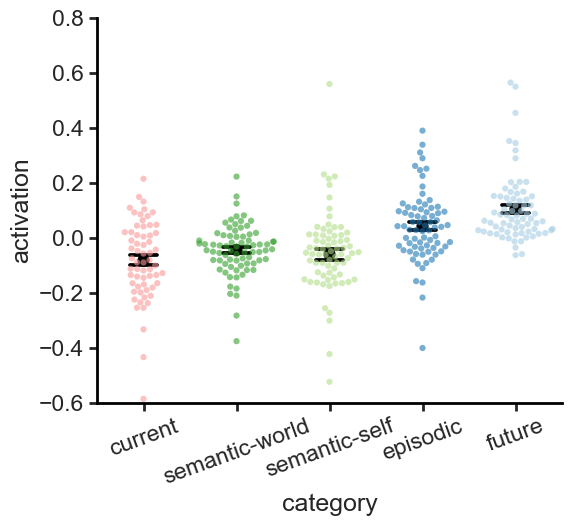

In [104]:
thisdata = mean_regout_univ[(mean_regout_univ['roi']=='PMC') & (mean_regout_univ['controlledvariable']=='duration')]

f, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(x='category', y='activation', data=thisdata, errorbar="se", capsize=.3, color="0", linestyles='', markers='o',order=category_order)
sns.swarmplot(x='category', y='activation', hue='category', data=thisdata, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6,order=category_order)
plt.xticks([0,1,2,3,4],category_order);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

#### PMC numwords controlled

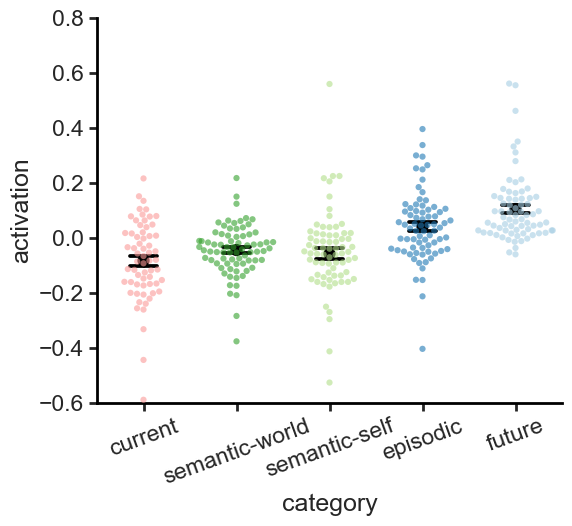

In [108]:
thisdata = mean_regout_univ[(mean_regout_univ['roi']=='PMC') & (mean_regout_univ['controlledvariable']=='numwords')]

f, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(x='category', y='activation', data=thisdata, errorbar="se", capsize=.3, color="0", linestyles='', markers='o',order=category_order)
sns.swarmplot(x='category', y='activation', hue='category', data=thisdata, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6,order=category_order)
plt.xticks([0,1,2,3,4],category_order);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

#### Hipp speech rate controlled

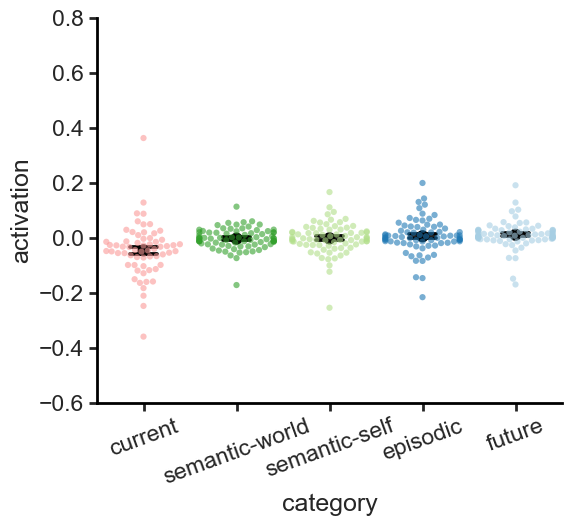

In [111]:
thisdata = mean_regout_univ[(mean_regout_univ['roi']=='hipp') & (mean_regout_univ['controlledvariable']=='density')]

f, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(x='category', y='activation', data=thisdata, errorbar="se", capsize=.3, color="0", linestyles='', markers='o',order=category_order)
sns.swarmplot(x='category', y='activation', hue='category', data=thisdata, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6,order=category_order)
plt.xticks([0,1,2,3,4],category_order);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

#### Hipp duration controlled

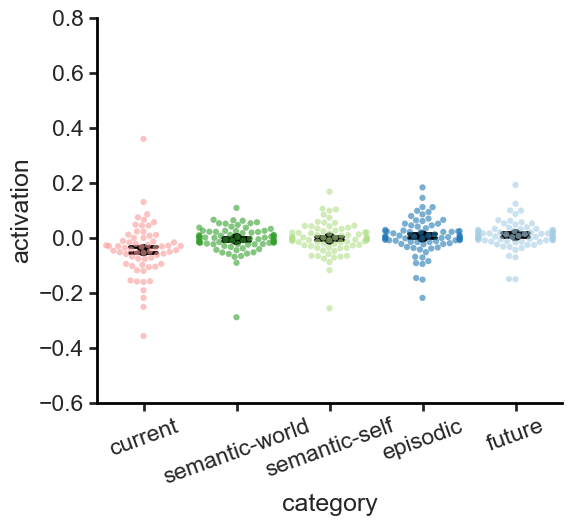

In [114]:
thisdata = mean_regout_univ[(mean_regout_univ['roi']=='hipp') & (mean_regout_univ['controlledvariable']=='duration')]

f, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(x='category', y='activation', data=thisdata, errorbar="se", capsize=.3, color="0", linestyles='', markers='o',order=category_order)
sns.swarmplot(x='category', y='activation', hue='category', data=thisdata, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6,order=category_order)
plt.xticks([0,1,2,3,4],category_order);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

#### Hipp numwords controlled

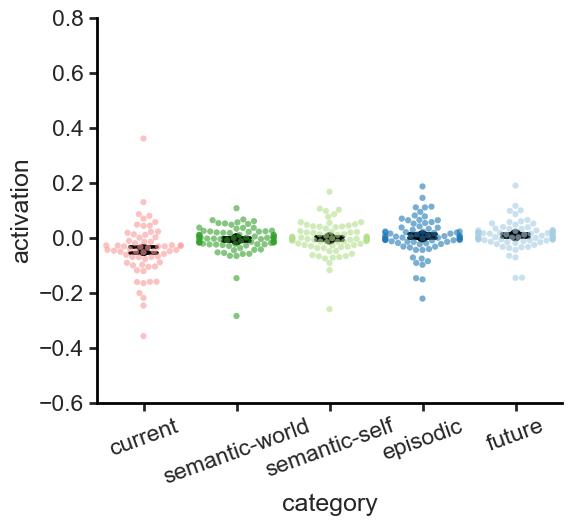

In [117]:
thisdata = mean_regout_univ[(mean_regout_univ['roi']=='hipp') & (mean_regout_univ['controlledvariable']=='numwords')]

f, ax = plt.subplots(figsize=(6, 5))
sns.pointplot(x='category', y='activation', data=thisdata, errorbar="se", capsize=.3, color="0", linestyles='', markers='o',order=category_order)
sns.swarmplot(x='category', y='activation', hue='category', data=thisdata, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6,order=category_order)
plt.xticks([0,1,2,3,4],category_order);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);
plt.ylim(-0.6,0.8)
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)

### Activation time course at thought transitions

In [123]:
# parameters
prenumTR = 2
postnumTR = 15
condvars = ['category_change_only','topic_change_only','strong_boundary']

sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})

def extract_transition_tc(behavdata, roitc, conditionvar, timevar, prenumTR, postnumTR):
    
    allsubjw = list()
    
    for i in range(len(behavdata)):
        
        if conditionvar == 'middle':
            boundarytimes = round((behavdata[i]['start_TR'] + behavdata[i]['end_TR'])/2)
            boundarytimes = boundarytimes[behavdata[i]['long']==True].apply(lambda x: int(x)).values
        else:
            boundarytimes = behavdata[i][timevar][behavdata[i][conditionvar]==True].values
        
        subjw = np.full((len(boundarytimes), prenumTR+postnumTR+1),np.nan)
        
        for r in range(len(boundarytimes)):
            
            for t in range(prenumTR+1): # TRs before target
                if ((boundarytimes[r]-t) > 0) & ((boundarytimes[r]-t) <= scandur):
                    subjw[r,prenumTR-t] = np.nanmean(roitc[i][:, boundarytimes[r]-1-t], axis=0)
                else:
                    subjw[r,prenumTR-t] = np.nan

            for t in range(postnumTR+1): # TRs after target
                if (boundarytimes[r]+t) <= scandur:
                    subjw[r,prenumTR+t] = np.nanmean(roitc[i][:, boundarytimes[r]-1+t], axis=0)
                else:
                    subjw[r,prenumTR+t] = np.nan

        # average across thoughts
        allsubjw.append(np.nanmean(subjw, axis=0))

    return allsubjw

def draw_boundary_activation_all(strongtc, topictc, categorytc, middletc, roiname):
    
    strongdf = pd.DataFrame(strongtc).reset_index()
    strong_longdf = pd.melt(strongdf, id_vars='index', value_vars=np.arange(prenumTR+postnumTR+1))
    strong_longdf.columns = ['Subject','TR','Activation']
    strong_longdf['Boundary'] = 3

    topicdf = pd.DataFrame(topictc).reset_index()
    topic_longdf = pd.melt(topicdf, id_vars='index', value_vars=np.arange(prenumTR+postnumTR+1))
    topic_longdf.columns = ['Subject','TR','Activation']
    topic_longdf['Boundary'] = 2

    catdf = pd.DataFrame(categorytc).reset_index()
    cat_longdf = pd.melt(catdf, id_vars='index', value_vars=np.arange(prenumTR+postnumTR+1))
    cat_longdf.columns = ['Subject','TR','Activation']
    cat_longdf['Boundary'] = 1
    
    middf = pd.DataFrame(middletc).reset_index()
    mid_longdf = pd.melt(middf, id_vars='index', value_vars=np.arange(prenumTR+postnumTR+1))
    mid_longdf.columns = ['Subject','TR','Activation']
    mid_longdf['Boundary'] = 0
    
    df_combined = pd.concat([strong_longdf, topic_longdf, cat_longdf, mid_longdf], axis=0)
    df_combined.reset_index(drop=True, inplace=True)
    
    f, ax = plt.subplots(1, 1, figsize=(6, 5))
    g = sns.lineplot(data=df_combined, x='TR', y='Activation', hue='Boundary', marker= 'o', markersize =7, linewidth=3, err_kws={'linewidth':0},
                     palette=["#737373", "#fdae61","#f46d43", "#bd0026"], errorbar='se',legend=False)
    for line in plt.gca().lines:
        line.set_markeredgewidth(0)  
    g.axvline(prenumTR, color='k', linewidth=1.5)
    ax.set(xticks=[0, prenumTR, prenumTR+postnumTR], xticklabels=[-prenumTR, 0, postnumTR], xlim=[0,prenumTR+postnumTR], ylim=[-.15,.2]);  
    ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
    ax.tick_params(axis='y', width=2)  # Set the y-axis tick width
    

#### PMC

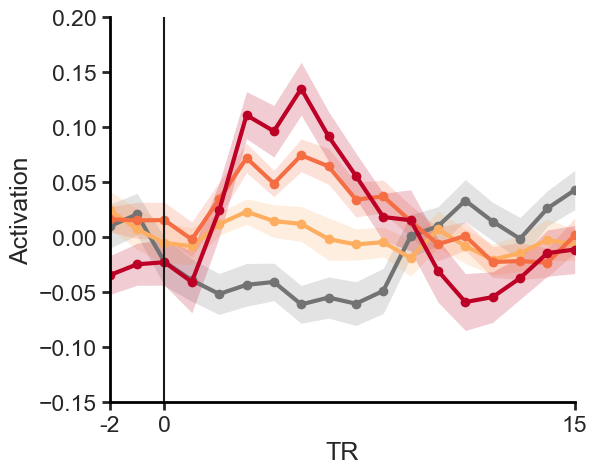

In [125]:
roitc = load_roi_tcs(subjects, 'PMC', 'fsaverage6', 1)
middletc = extract_transition_tc(thoughtdata, roitc, 'middle', 'end_TR', prenumTR, postnumTR)
boundarytc = list()
for i in range(len(condvars)):
    boundarytc.append(extract_transition_tc(thoughtdata, roitc, condvars[i], 'end_TR', prenumTR, postnumTR))
draw_boundary_activation_all(boundarytc[2], boundarytc[1], boundarytc[0], middletc, 'PMC')

#### Hipp

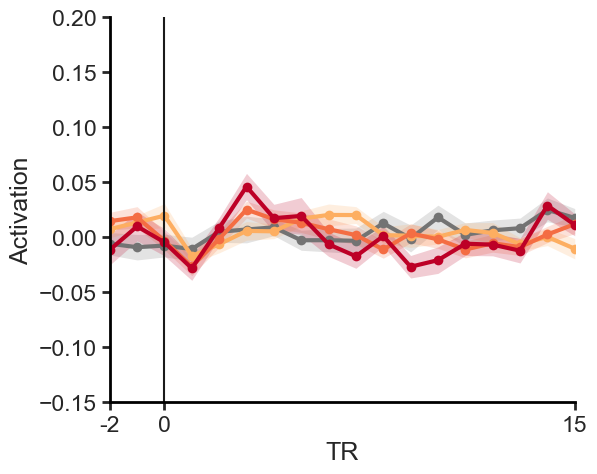

In [127]:
# hipp
roitc = load_roi_tcs(subjects, 'hipp', 'MNI152NLin2009cAsym', 1)
middletc = extract_transition_tc(thoughtdata, roitc, 'middle', 'end_TR', prenumTR, postnumTR)
boundarytc = list()
for i in range(len(condvars)):
    boundarytc.append(extract_transition_tc(thoughtdata, roitc, condvars[i], 'end_TR', prenumTR, postnumTR))
draw_boundary_activation_all(boundarytc[2], boundarytc[1], boundarytc[0], middletc, 'hipp')

## Functional connectivity

In [ ]:
# Compute functional connectivity
subregionnames = ['ContB_IPL', 'ContB_PFCd_L', 'ContB_PFCld_R', 'ContB_PFClv',
       'ContB_PFCmp', 'ContB_Temp', 'DefaultA_IPL', 'DefaultA_PFCd',
       'DefaultA_PFCm', 'DefaultA_Temp_R', 'DefaultA_pCunPCC',
       'DefaultC_IPL', 'DefaultC_PHC', 'DefaultC_Rsp', 'DefaultC_hipp']

# list of region X region connectivity arrays 
corr = np.full((len(subregionnames), len(subregionnames), len(subjects)),np.nan) 

for s in range(len(subjects)):
    
    # load network subregion timecourses (bilateral)
    tc = np.load(os.path.join('roitc',subjects[s], subjects[s] + '_bilateral_subregion_tc.npy'))

    # drop the beginning & motion outlier TRs
    confdf = pd.read_csv(os.path.join('confounds',subjects[s] + '_framewise_displacement.csv'))
    tc = drop_TRs(tc, np.array(confdf['framewise_displacement']), 2, 10)

    # correlation across regions
    if np.isnan(tc).all():
        corr[:,:,s] = np.full((tc.shape[0], tc.shape[0]), np.nan)
    else:
        tc = tc[:, ~np.isnan(tc).any(axis=0)] # drop NaNs
        corr[:,:,s] = np.corrcoef(tc)

<Axes: >

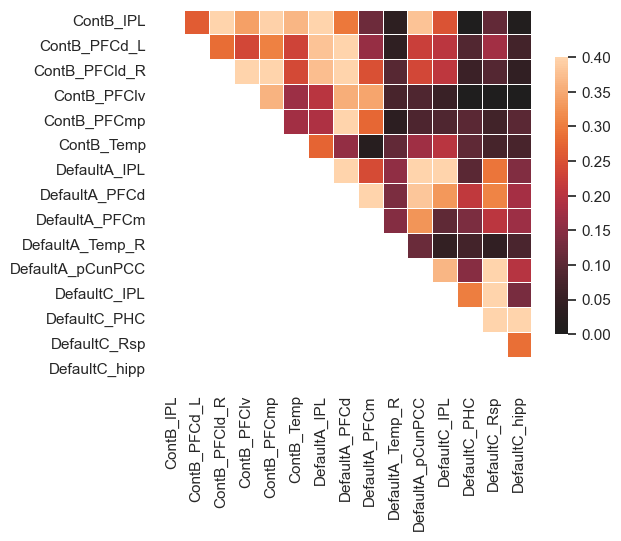

In [227]:
# mean connectivity
meancorr = np.nanmean(corr, axis=2)
sns.set_theme(style="white", font_scale=1, rc={"text.color": "black"})
f, ax = plt.subplots(figsize=(6, 6))
mask = np.tril(np.ones_like(meancorr, dtype=bool))
sns.heatmap(meancorr, vmin=0, vmax=.4, cmap='icefire', square=True, center=0, linewidths=0.5, xticklabels=subregionnames, yticklabels=subregionnames,cbar_kws={"shrink": 0.6}, mask=mask)

In [229]:
# correlation with thought network clustering
clustering = list()
for s in subjects:
    clustering.append(sdf['Average clustering'][sdf['BIDS_ID']==s].values[0])
clustering = np.array(clustering)

rs = np.full((corr.shape[0],corr.shape[1]), np.nan)
ps = np.full((corr.shape[0],corr.shape[1]), np.nan)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        valid_indices = ~np.isnan(corr[i][j][:])
        res = sp.stats.pearsonr(corr[i][j][valid_indices], clustering[valid_indices])
        rs[i][j] = res[0]
        ps[i][j] = res[1]

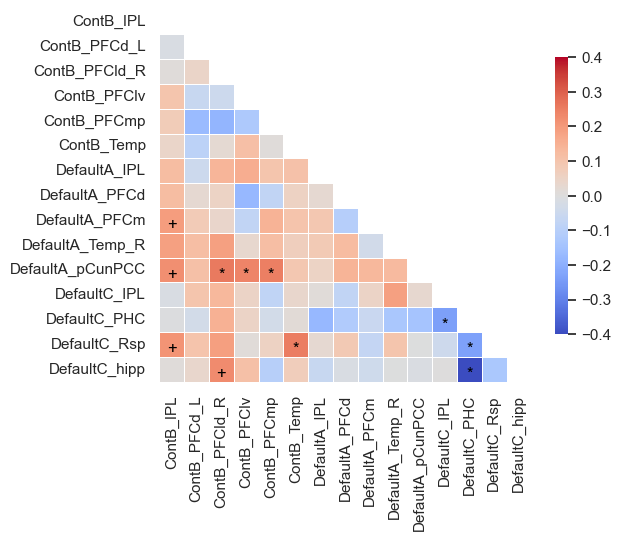

In [231]:
f, ax = plt.subplots(figsize=(6, 6))
mask = np.triu(np.ones_like(meancorr, dtype=bool))
sns.heatmap(rs, vmin=-.4, vmax=.4, cmap='coolwarm', square=True, center=0, linewidths=0.5, xticklabels=subregionnames, yticklabels=subregionnames,cbar_kws={"shrink": 0.6}, mask=mask)

pthres = 0.05 
for i in range(len(subregionnames)):
    for j in range(len(subregionnames)):
        if i > j:
            if ps[i][j] < pthres:
                label = '*'
            elif (ps[i][j] >= pthres) & (ps[i][j] < 0.1):
                label = '+'
            else:
                label = ''
            plt.text(j + 0.5, i + 0.7, label, ha='center', va='center', color='black')

In [233]:
# within/between network connectivity

networknames = ['ContB','DefaultA','DefaultC']
networkidx = list()
for n in range(len(networknames)):
    networkidx.append([i for i, name in enumerate(subregionnames) if name.startswith(networknames[n])])

# list of network X network connectivity matrices
corr_network = np.full((len(networknames), len(networknames), np.shape(corr)[2]),np.nan) 
        
for s in range(len(subjects)):

    # region-by-region connectivity
    thiscorr = corr[:,:,s]

    # replace within-region connectivity with NaN
    np.fill_diagonal(thiscorr, np.nan)

    # average across regions within each network
    for i in range(len(networkidx)):
        iidx = networkidx[i]
        for j in range(len(networkidx)):
            jidx = networkidx[j]
            corr_network[i,j,s] = np.nanmean(thiscorr[iidx[0]:(iidx[-1]+1),jidx[0]:(jidx[-1]+1)])
            
contB_defA = corr_network[0][1][:]
contB_defC = corr_network[0][2][:]
defA_defC = corr_network[1][2][:]
defC_within = corr_network[2][2][:]

In [235]:
# correlation with clustering
res = sp.stats.pearsonr(contB_defA, clustering)
lo, hi = res.confidence_interval(confidence_level=0.95)
print(f"control B - default A: r = {res[0]: .3f} , p = {res[1]: .5f}, 95% CI = [{lo: .3f} , {hi: .3f}]")
res = sp.stats.pearsonr(contB_defC, clustering)
lo, hi = res.confidence_interval(confidence_level=0.95)
print(f"control B - default C: r = {res[0]: .3f} , p = {res[1]: .5f}, 95% CI = [{lo: .3f} , {hi: .3f}]")
res = sp.stats.pearsonr(defA_defC, clustering)
lo, hi = res.confidence_interval(confidence_level=0.95)
print(f"default A - default C: r = {res[0]: .3f} , p = {res[1]: .5f}, 95% CI = [{lo: .3f} , {hi: .3f}]")
res = sp.stats.pearsonr(defC_within, clustering)
lo, hi = res.confidence_interval(confidence_level=0.95)
print(f"default C within: r = {res[0]: .3f} , p = {res[1]: .5f}, 95% CI = [{lo: .3f} , {hi: .3f}]")

control B - default A: r =  0.236 , p =  0.04147, 95% CI = [ 0.010 ,  0.439]
control B - default C: r =  0.133 , p =  0.25572, 95% CI = [-0.097 ,  0.349]
default A - default C: r = -0.041 , p =  0.72887, 95% CI = [-0.265 ,  0.188]
default C within: r = -0.285 , p =  0.01309, 95% CI = [-0.481 , -0.062]


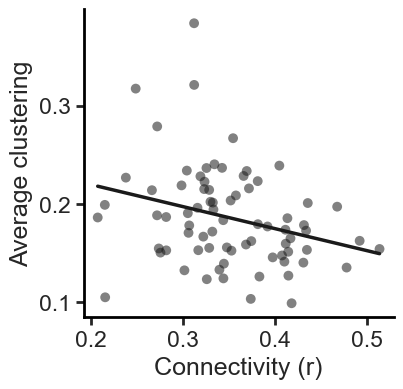

In [237]:
# defaultC within
sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})
f, axes = plt.subplots(figsize=(4, 4));
sns.regplot(x=defC_within, y=clustering, color='k', scatter_kws={"edgecolor": "none", "s": 50, "alpha":0.55}, line_kws={'linewidth': 2.5}, ci=None)
plt.xlabel('Connectivity (r)')
plt.ylabel('Average clustering')
axes.tick_params(axis='x', width=2)  # Set the x-axis tick width
axes.tick_params(axis='y', width=2)  # Set the y-axis tick width

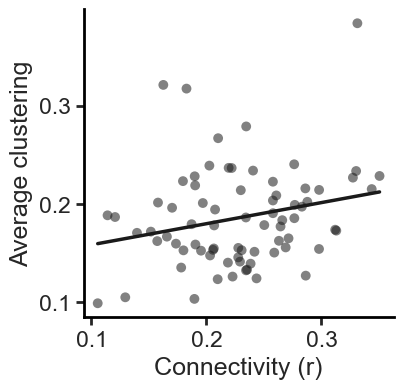

In [239]:
# defaultA - controlB
f, axes = plt.subplots(figsize=(4, 4));
sns.regplot(x=contB_defA, y=clustering, color='k', scatter_kws={"edgecolor": "none", "s": 50, "alpha":0.55}, line_kws={'linewidth': 2.5}, ci=None)
plt.xlabel('Connectivity (r)')
plt.ylabel('Average clustering')
axes.tick_params(axis='x', width=2)  # Set the x-axis tick width
axes.tick_params(axis='y', width=2)  # Set the y-axis tick width